## Applying Boost at Provider Level with Bayesian Optimization
#### We can use Bayesian optimization to allocate boost at the provider level to optimize a combination of ATA and expected cost given we have (or can estimate) the following inputs:

> provider acceptance probability ... at 0 boost and every boost level

> out of network probability ... at 0 boost and every boost level

> average OON cost in a given area

> Assumed OON ATA probability ... where ATA is probability of arrival time exceeding the threshold

## Configuration

#### Import Packages

In [1]:
import collections
import datetime
import itertools
import matplotlib.pyplot as plt
import mcdm
import numpy as np
import ortools
import pandas as pd
import random
import seaborn as sns
import skopt
import time
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [12, 8]

#### Network Configuration (no. in-network supplier & boost levels)

In [2]:
config_n_suppliers = 8
config_boost_levels = list(range(0,50,5))

#### Weight Configuration (weights to apply in optimization for ata & cost)

In [3]:
config_cost_weight = 0.75
config_ata_weight = 1 - config_cost_weight

#### Assumed Average OON Cost & ATA

In [4]:
config_oon_avg_cost = 250
config_oon_ata = 0.95

## Define Functions & Classes

#### Data Simulation

In [5]:
def create_bimodal_distribution(mu1, mu2, std1, std2, n):
    """
    Create bimodal distribution given means (mu), standard
    deviations (std), and number of observations (n)
    Returns:
        list
    """
    n1 = int(n / 2)
    n2 = n - n1
    dist1 = np.random.normal(mu1, std1, n1)
    dist2 = np.random.normal(mu2, std2, n2)
    return list(np.concatenate([dist1, dist2]))


def normalize_to_median(iterable):
    """
    Normalize using (Xi - MEDIAN(X)) / STDEV(X) rather than the conventional mean
    Args:
        iterable: some iterable object with floats
    Returns:
        (normalized) iterable
    """
    median_x = np.median(iterable)
    stdev_x = np.std(iterable)
    return [(x - median_x) / stdev_x for x in iterable]


def min_max_normalize(iterable):
    """
    Normalize using (Xi - MEDIAN(X)) / STDEV(X) rather than the conventional mean
    Args:
        iterable: some iterable object with floats
    Returns:
        (normalized) iterable
    """
    return [(x - min(iterable)) / (max(iterable) - min(iterable)) for x in iterable]


def print_timestamp_message(message, timestamp_format = '%Y-%m-%d %H:%M:%S'):
    """
    Print formatted timestamp followed by custom message
    Args:
        message (str): string to concatenate with timestamp
        timestamp_format (str): format for datetime string. defaults to '%Y-%m-%d %H:%M:%S'
    """
    ts_string = datetime.datetime.fromtimestamp(time.time()).strftime(timestamp_format)
    print(f'{ts_string}: {message}')
    

class SimulatedSuppliers:
    def __init__(self,
                 n_suppliers,
                 accept_plot_attribs = {'x_label' : 'Boost Dollars',
                                        'y_label' : 'Acceptance Probability',
                                        'marker' : 'o'},
                 base_cost_range = [80, 130],
                 boost_values = list(range(0,50,5)),
                 mean_acceptance1 = 0.05,
                 stdev_acceptance1 = 0.07,
                 mean_acceptance2 = 0.25,
                 stdev_acceptance2 = 0.25,
                 random_seed = 832021):
        """
        Simulate supplier data with cost, ata service level probability, and acceptance probabilities
        given specified ranges
        
        Example:
            supplier_simulation = SimulatedSuppliers(supplier_names = [f'Supplier {n}' for n in range(1,4)])
            supplier_simulation_df = supplier_simulation.generate_supplier_info() 
        """
        self.n_suppliers = n_suppliers
        self.accept_plot_attribs = accept_plot_attribs
        self.base_cost_range = base_cost_range
        self.boost_values = boost_values
        self.mean_acceptance1 = mean_acceptance1
        self.stdev_acceptance1 = stdev_acceptance1
        self.mean_acceptance2 = mean_acceptance2
        self.stdev_acceptance2 = stdev_acceptance2
        self.random_seed = random_seed
        
        
    def get_random_boost_probs(self):
        """
        Generate random acceptance probabilities given a range of boost values
        that follow a 2nd order polynomial pattern
        Args:
            boost_values (list): list of dollar values used in boost
            mean_acceptance1 (float): average acceptance rate at $0 boost for part of bimodal distribution
            stdev_acceptance1 (float): standard deviation of acceptance rate at $0 boost for part of bimodal distribution
            mean_acceptance2 (float): average acceptance rate at $0 boost for part of bimodal distribution
            stdev_acceptance2 (float): standard deviation of acceptance rate at $0 boost for part of bimodal distribution
            supplier_name (str): name of simulated supplier
        Returns:
            pandas.DataFrame object with fields 'boost_dollars', 'accept_prob', and 'supplier'
        """
        np.random.seed(self.random_seed)
        random.seed(self.random_seed)
        supplier_names = [f'Supplier {n}' for n in range(1, (self.n_suppliers + 1))]
        boost_df_list = []
        for sn in supplier_names:
            acceptance_distr = create_bimodal_distribution(self.mean_acceptance1, self.mean_acceptance2,
                                                           self.stdev_acceptance1, self.stdev_acceptance2, 1000)
            
            b0 = random.choice([x for x in acceptance_distr if (x > 0) and (x < 1)])
            max_b1 = ((1 - b0) / max(self.boost_values))
            b1 = random.choice(np.linspace(0, max_b1, 100))
            max_b2 = (1 - (b0 + (b1 * max(self.boost_values)))) / max(self.boost_values)**2
            b2 = random.choice(np.linspace(0, max_b2, 100))
            probs = []
            for x in self.boost_values:
                p = b0 + (b1 * x) + (b2 * x**2)
                probs.append(p)
            boost_df = pd.DataFrame({'boost_dollars' : self.boost_values, 'accept_prob' : probs})
            boost_df['supplier'] = sn
            boost_df_list.append(boost_df)
        output_df = pd.concat(boost_df_list, axis = 0)
        return output_df
    
    
    def generate_supplier_info(self):
        """
        Generate a pandas.DataFrame object with costs in a given range and ata probabilities
        0 to 1 representing the likelihood of completing service in under 45 minutes
        Args:
            supplier_names (list): list of supplier names
            base_cost_range (list): minimum and maximum baseline cost for each supplier
        Returns:
            pandas.DataFrame object with fields 'supplier', 'base_cost', 'ata_prob' which
            is merged with the output of get_random_boost_probs()
        """
        random.seed(self.random_seed)
        supplier_names = [f'Supplier {n}' for n in range(1, (self.n_suppliers + 1))]
        boost_prob_df = self.get_random_boost_probs()
        ata_probs = [random.choice(np.linspace(0,1,100)) for i in range(len(supplier_names))]
        base_cost = [random.choice(np.linspace(self.base_cost_range[0], self.base_cost_range[1], 100)) for i in range(len(supplier_names))]
        supplier_info_df = pd.DataFrame({'base_cost' : base_cost, 'ata_prob' : ata_probs})
        supplier_info_df = supplier_info_df.sort_values('ata_prob', ascending = True)
        supplier_info_df['supplier'] = supplier_names
        supplier_boost_info_df = pd.merge(supplier_info_df, boost_prob_df, on = 'supplier', how = 'left')
        supplier_boost_info_df['total_cost'] = supplier_boost_info_df['base_cost'] + supplier_boost_info_df['boost_dollars']
        supplier_boost_info_df['ata_per_dollar'] = supplier_boost_info_df['ata_prob'] / supplier_boost_info_df['total_cost']
        supplier_boost_info_df = supplier_boost_info_df.sort_values('ata_per_dollar', ascending = False)
        
        return supplier_boost_info_df
    
    
    def generate_supplier_dict(self):
        """
        Wrapper around generate_supplier_info() that converts pandas.DataFrame
        object into a nested dictionary
        """
        supplier_simulation_df = self.generate_supplier_info()
        supplier_names = sorted(list(set(supplier_simulation_df['supplier'])))
        supplier_dict_list = []
        for i, cbo in enumerate(supplier_names):
            ata_prob = list(supplier_simulation_df[supplier_simulation_df.supplier == cbo]['ata_prob'])[0]
            base_cost = list(supplier_simulation_df[supplier_simulation_df.supplier == cbo]['base_cost'])[0]
            boost_dollars = list(supplier_simulation_df[supplier_simulation_df.supplier == cbo]['boost_dollars'])
            accept_prob = list(supplier_simulation_df[supplier_simulation_df.supplier == cbo]['accept_prob'])
            total_cost = list(supplier_simulation_df[supplier_simulation_df.supplier == cbo]['total_cost'])
            s_dict = {'supplier' : cbo, 'ata_prob' : ata_prob, 'base_cost' : base_cost, 'boost_dict' : dict(zip(boost_dollars, zip(accept_prob, total_cost)))}
            supplier_dict_list.append(s_dict)
            
        supplier_dict = dict(zip(range(len(supplier_names)), supplier_dict_list))
        return supplier_dict

        
    
    def plot_supplier_acceptance(self):
        """
        Plot curves of acceptance probability for each supplier based on boost dollars
        offered using the output of the generate_supplier_info() attribute
        Args:
            accept_plot_attribs (dict): dictionary with plot attributes defined
            by keys 'x_label', 'y_label', and 'marker'
        Returns:
            None
        """
        sup_df = self.generate_supplier_info()
        sns.lineplot(x = 'boost_dollars',
                     y = 'accept_prob',
                     hue = 'supplier',
                     marker = self.accept_plot_attribs.get('marker'),  data = sup_df)
        plt.ylabel(self.accept_plot_attribs.get('y_label'))
        plt.xlabel(self.accept_plot_attribs.get('x_label'))
        plt.show()



def make_supplier_network(sup_dictionary : dict, boost_levels : list):
    
    supplier_list = [sup_dictionary.get(i).get('supplier') for i, x in enumerate(sup_dictionary)]
    ata_list = [sup_dictionary.get(i).get('ata_prob') for i, x in enumerate(sup_dictionary)]
    accept_prob_list = [sup_dictionary.get(i).get('boost_dict').get(boost_levels[i])[0] for i, x in enumerate(sup_dictionary)]
    base_cost_list = [sup_dictionary.get(i).get('base_cost') for i, x in enumerate(sup_dictionary)]
    total_cost_list = [sup_dictionary.get(i).get('boost_dict').get(boost_levels[i])[1] for i, x in enumerate(sup_dictionary)]
    selection_prob_list = []
    for i, ap in enumerate(accept_prob_list):
        if i == 0:
            selection_prob_list.append(ap)
        else:
            selection_prob_list.append((1 - sum(selection_prob_list)) * ap)
    output_dict = dict(zip(['supplier', 'ata_prob', 'accept_prob', 'base_cost', 'boost_dollars', 'total_cost', 'selection_prob'],
                           [supplier_list, ata_list, accept_prob_list, base_cost_list, boost_levels, total_cost_list, selection_prob_list]))
    return output_dict


#### Calculating Expected Results

In [6]:
def calc_exp_network_results(boost_levels : list, sup_dictionary : dict, oon_avg_cost = config_oon_avg_cost, oon_ata = config_oon_ata):
    """
    Given a supplier dictionary created with method SimulatedSuppliers.generate_supplier_dict()
    and boost dollar amounts corresponding to each supplier, calculate the expected cost where:
        network cost = sum-product {selection probability, supplier cost} X in-network probability
        OON cost = average OON supplier cost X OON probability
        expected cost = network cost + OON cost
    Args:
        boost_levels (list): list of boost dollar amounts corresponding with each supplier in supplier dictionary
        supplier_dictionary (dict): dictionary output from method SimulatedSuppliers.generate_supplier_dict()
    Returns:
        float(s): expected cost, expected ATA (probability of arriving outside of time limit)
    """
    supplier_network = make_supplier_network(sup_dictionary = sup_dictionary, boost_levels = boost_levels)
    
    # In Network Estimate
    net_exp_cost = np.dot(supplier_network.get('selection_prob'), supplier_network.get('total_cost'))
    net_exp_ata = np.dot(supplier_network.get('selection_prob'), supplier_network.get('ata_prob'))
    
    # Out of Network Estimate
    oon_prob = 1 - np.sum(supplier_network.get('selection_prob'))
    
    # Combined Probabilistic Estimates
    exp_cost = net_exp_cost + (oon_avg_cost * oon_prob)
    exp_ata = net_exp_ata + (oon_ata * oon_prob)
    
    return exp_cost, exp_ata

## Exploration

#### Create Simulated Data

In [7]:
supplier_simulation = SimulatedSuppliers(n_suppliers = config_n_suppliers, random_seed = 762021)
supplier_dict = supplier_simulation.generate_supplier_dict()

#### For each supplier, we have a name, ATA probability, baseline cost, and (acceptance probability, total cost) for each boost dollar amount

In [8]:
supplier_dict

{0: {'supplier': 'Supplier 1',
  'ata_prob': 0.21212121212121213,
  'base_cost': 108.78787878787878,
  'boost_dict': {0: (0.6243064648664821, 108.78787878787878),
   5: (0.6386895444631887, 113.78787878787878),
   10: (0.6540096325026774, 118.78787878787878),
   15: (0.6702667289849484, 123.78787878787878),
   20: (0.6874608339100016, 128.78787878787878),
   25: (0.7055919472778369, 133.78787878787878),
   30: (0.7246600690884543, 138.78787878787878),
   35: (0.744665199341854, 143.78787878787878),
   40: (0.7656073380380358, 148.78787878787878),
   45: (0.7874864851769999, 153.78787878787878)}},
 1: {'supplier': 'Supplier 2',
  'ata_prob': 0.23232323232323235,
  'base_cost': 104.74747474747474,
  'boost_dict': {0: (0.21798357818704706, 104.74747474747474),
   5: (0.23353661105218013, 109.74747474747474),
   10: (0.2556205583448154, 114.74747474747474),
   15: (0.2842354200649529, 119.74747474747474),
   20: (0.3193811962125926, 124.74747474747474),
   25: (0.3610578867877345, 129.7474

#### Plot supplier acceptance curves

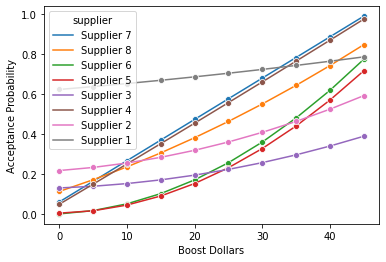

In [9]:
supplier_simulation.plot_supplier_acceptance()

#### Let's look at the supplier network when boost is zero dollars

In [10]:
no_boost_supplier_network = make_supplier_network(sup_dictionary = supplier_dict, boost_levels = [0] * config_n_suppliers)
no_boost_df = pd.DataFrame.from_dict(no_boost_supplier_network)
no_boost_df

,supplier,ata_prob,accept_prob,base_cost,boost_dollars,total_cost,selection_prob
0,Supplier 1,0.212121,0.624306,108.787879,0,108.787879,0.624306
1,Supplier 2,0.232323,0.217984,104.747475,0,104.747475,0.081895
2,Supplier 3,0.292929,0.130790,80.000000,0,80.000000,0.038426
3,Supplier 4,0.303030,0.049135,120.404040,0,120.404040,0.012548
4,Supplier 5,0.555556,0.004545,126.464646,0,126.464646,0.001104
5,Supplier 6,0.575758,0.000667,98.181818,0,98.181818,0.000161
6,Supplier 7,0.747475,0.060760,82.020202,0,82.020202,0.014677
7,Supplier 8,0.828283,0.113267,94.141414,0,94.141414,0.025698


#### Let's calculate expected cost and ATA for this network. We need to assume an average OON cost and ATA for this.

In [11]:
baseline_cost, baseline_ata = calc_exp_network_results(boost_levels = [0] * config_n_suppliers,
                                                       sup_dictionary = supplier_dict)

In [12]:
print(f'At $0 boost, we expect the cost to average ${round(baseline_cost, 2)} and the ATA to average {round(baseline_ata,3)}')

At $0 boost, we expect the cost to average $135.15 and the ATA to average 0.391


#### Here's how this is calculated manually

In [13]:
oon_probability = 1 - np.sum(no_boost_df['selection_prob'])
print(f'The probability of this rescue going out of network is {round(oon_probability, 3)} (which would cost ${config_oon_avg_cost})')

The probability of this rescue going out of network is 0.201 (which would cost $250)


In [14]:
expected_no_boost_cost = np.dot(no_boost_df['selection_prob'], no_boost_df['total_cost']) + (config_oon_avg_cost * oon_probability)
print(f'Expected cost, manual calculation: {round(expected_no_boost_cost,2)}')

Expected cost, manual calculation: 135.15


## Bayesian Optimization

#### We need to how much (if any) boost to apply to each supplier
#### Before applying Bayesian optimization, we need a function that will take boosts as an argument and return some weighted combination of ATA & cost

#### Note that we have a function that already outputs {expectected cost, expected ata} for any network

#### We will create metrics that represent % change in expected cost, ata *vs. $0 boost*

#### These will be weighted and summed to create a single optimization metric

In [15]:
def weighted_improvement_vs_no_boost(boost_levels : list, sup_dictionary = supplier_dict, cost_weight = config_cost_weight):
    """
    Wrapper calc_exp_network_results() to compare expected cost and expected ATA with a boost of $0.
    This normalization allows for results to pass into MCDM before bayesian optimization is applied.
    """
    
    # Create expected cost and ATA for $0 boost vs. specified boosts
    no_boost_exp_cost, no_boost_exp_ata = calc_exp_network_results(sup_dictionary = sup_dictionary, boost_levels = [0] * len(sup_dictionary))
    network_exp_cost, network_exp_ata = calc_exp_network_results(sup_dictionary = sup_dictionary, boost_levels = boost_levels)
    
    # Calculate % change in exp. cost and ATA
    # Note: ata_change is multiplied by -1 as we want to maximize this
    cost_change = (network_exp_cost - no_boost_exp_cost) / no_boost_exp_cost
    ata_change = (network_exp_ata - no_boost_exp_ata) / no_boost_exp_ata
    
    weighted_improvement = (cost_change * cost_weight) + (ata_change * (1 - cost_weight))
    
    return weighted_improvement

#### Now we can pass this function to our bayesian optimization object, passing the possible levels of boost as an argument

In [16]:
print_timestamp_message('Starting boost optimization')
bayes_results = skopt.gp_minimize(func = weighted_improvement_vs_no_boost,
                                  dimensions = list(itertools.repeat(config_boost_levels, config_n_suppliers)),
                                  acq_func = 'EI',
                                  n_calls = 150,
                                  n_initial_points = 20,
                                  random_state = 8122021)
print_timestamp_message('Finished boost optimization')

2021-08-25 11:33:44: Starting boost optimization
2021-08-25 11:35:29: Finished boost optimization


#### Let's check the optimal values of boost and see what that network looks like

In [17]:
optimal_supplier_network = make_supplier_network(sup_dictionary = supplier_dict, boost_levels = bayes_results.x)
optimal_supplier_network_df = pd.DataFrame.from_dict(optimal_supplier_network)

In [18]:
optimal_supplier_network_df

,supplier,ata_prob,accept_prob,base_cost,boost_dollars,total_cost,selection_prob
0,Supplier 1,0.212121,0.624306,108.787879,0,108.787879,0.624306
1,Supplier 2,0.232323,0.233537,104.747475,5,109.747475,0.087738
2,Supplier 3,0.292929,0.340535,80.000000,40,120.000000,0.098059
3,Supplier 4,0.303030,0.455189,120.404040,20,140.404040,0.086439
4,Supplier 5,0.555556,0.016323,126.464646,5,131.464646,0.001689
5,Supplier 6,0.575758,0.360458,98.181818,30,128.181818,0.036683
6,Supplier 7,0.747475,0.991184,82.020202,45,127.020202,0.064512
7,Supplier 8,0.828283,0.644596,94.141414,35,129.141414,0.000370


#### Check how expected cost, ATA compare to our $0 boost baseline

In [19]:
optimal_cost, optimal_ata = calc_exp_network_results(boost_levels = bayes_results.x, sup_dictionary = supplier_dict)
baseline_cost, baseline_ata = calc_exp_network_results(boost_levels = [0] * config_n_suppliers, sup_dictionary = supplier_dict)
optimal_oon = 1 - np.sum(optimal_supplier_network_df['selection_prob'])
baseline_oon = 1 - np.sum(no_boost_df['selection_prob'])
comparison_df = pd.DataFrame({'Expected Cost' : [optimal_cost, baseline_cost],
                              'Expected ATA' : [optimal_ata, baseline_ata],
                              'OON Probability' : [f'{round(optimal_oon * 100,3)}%', f'{round(baseline_oon * 100,3)}%'],
                              'Value' : ['Optimized Boost', 'Baseline, $0 Boost']})
comparison_df

,Expected Cost,Expected ATA,OON Probability,Value
0,114.666639,0.278510,0.02%,Optimized Boost
1,135.154766,0.390601,20.118%,"Baseline, $0 Boost"


#### All 3 metrics show improvement